**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 6**

**Problem 6.7**


**In this problem, we want to evaluate the impact of spectral variation throughout the day on MJSCs. For the III-V 3J solar cell described in Problem S6.1, calculate the short-circuit current density of each subcell every hour during March 21, 2023, assuming that the solar cell is used in Phoenix, AZ, USA (lat, lon 33.448376⁰, -112.074036⁰), and oriented towards the south at a tilt angle of 25⁰.**

**To that end, use the spectra generator in pvlib assuming atmospheric pressure 101300 Pa, atmospheric water vapor content 0.5 cm and ozone content 0.31 atm-cm, aerosol turbidity at 500 nm equal to 0.1, and ground reflectivity 0.2.**

**Plot the evolution of the ratio of the short-circuit current of the top and middle subcell ($J_{SC,top}$/$J_{SC,middle}$) throughout the day.**

We will use the packages [pvlib](https://pvlib-python.readthedocs.io/en/stable/), [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results.

In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import numpy as np

Similar to Problem 6.1, we define the relevant constants and retrieve the QE of the triple junction solar cell.

In [2]:
h=6.63*10**(-34)   # [J·s] Planck constant
e=1.60*10**(-19)   # [C] electron charge
c =299792458       # [m/s] Light speed

In [3]:
QE_data = pd.read_csv('data/QE_triple_junction_solar_cell.csv', index_col=0, header=0) 
QE_top=QE_data['QE top'].dropna()
QE_data.set_index('nm middle', inplace=True)
QE_mid=QE_data['QE middle'].dropna()
QE_data.set_index('nm bottom', inplace=True)
QE_bot=QE_data['QE bottom'].dropna()

We can plot the Quantum Efficiency.

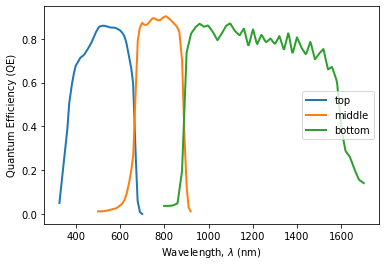

In [4]:
plt.plot(QE_top, linewidth=2, label='top')
plt.plot(QE_mid, linewidth=2, label='middle')
plt.plot(QE_bot, linewidth=2, label='bottom')
plt.ylabel('Quantum Efficiency (QE)')
plt.xlabel('Wavelength, $\lambda$ (nm)');
plt.legend()

We start by defining the location and weather variables, calculating the position of the Sun, the angle of incidence, and the relative air mass.

In [12]:
lat,lon = 33.448376, -112.074036 #Phoenix, Arizona, USA
tilt = 25
orientation = 180 # pvlib sets orientation origin at North -> South=180
tz = pytz.timezone('US/Arizona')

pressure = 101300           # [Pa] atmospheric pressure
water_vapor_content = 0.5   # [cm] Atmospheric water vapor content
tau500 = 0.1                # [unitless] aerosol turbidity at 500 nm
ozone = 0.31                # [atm-cm] Atmospheric ozone content 
ground_reflectivity = 0.2   

times = pd.date_range('2023-03-21 07:00', freq='h', periods=12, tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, lat, lon)

aoi = pvlib.irradiance.aoi(tilt,
                           orientation, 
                           solpos.apparent_zenith, 
                           solpos.azimuth)


relative_airmass = pvlib.atmosphere.get_relative_airmass(solpos.apparent_zenith,
                                                           model='kasten1966') # later versions of SPECTRL2 use 'kastenyoung1989'

We calculate the solar spectra for every hour throghout the day and plot them. 

In [13]:
spectra = pvlib.spectrum.spectrl2(apparent_zenith=solpos.apparent_zenith,
                                  aoi=aoi,
                                  surface_tilt=tilt,
                                  ground_albedo=ground_reflectivity,
                                  surface_pressure=pressure,
                                  relative_airmass=relative_airmass,
                                  precipitable_water=water_vapor_content,
                                  ozone=ozone, 
                                  aerosol_turbidity_500nm=tau500)

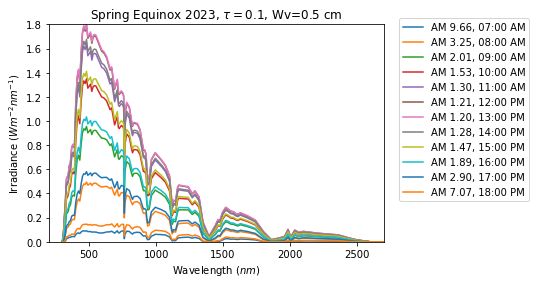

In [19]:
plt.figure()
plt.plot(spectra['wavelength'], spectra['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.title(r"Spring Equinox 2023, $\tau=0.1$, Wv=0.5 cm")
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
time_labels = times.strftime("%H:%M %p")
labels = ["AM {:0.02f}, {}".format(*vals)
        for vals in zip(relative_airmass, time_labels)]
plt.legend(labels, ncol=1,bbox_to_anchor=(1.45, 1.05))
plt.show()

For the top and middle subcells, we calculate the spectral response, interpolate the spectrum, and integrate to obtain the short-circuit current density using Eq. 3.5.

$J=\int SR(\lambda) \cdot G(\lambda) \ d\lambda$

Then, we calculate the ratio betwen both subcell short-circuit current.

In [10]:
SR_top = pd.Series(index=QE_top.index,
                data=[QE_top.loc[i]*e*i*0.000000001/(h*c) for i in QE_top.index])
SR_mid = pd.Series(index=QE_mid.index,
            data=[QE_mid.loc[i]*e*i*0.000000001/(h*c) for i in QE_mid.index])

ratios = pd.Series(index=times, dtype='float')

for i, time in enumerate(times):
    spectrum=spectra['poa_global'][:,i]

    spectrum_interpolated_top=np.interp(SR_top.index, spectra['wavelength'], spectrum)
    J_top = np.trapz([x*y for x,y in zip(SR_top, spectrum_interpolated_top)], x=SR_top.index)*1000/10000 # A-> mA ; m2 -> cm2
    
    spectrum_interpolated_mid=np.interp(SR_mid.index, spectra['wavelength'], spectrum)
    J_mid = np.trapz([x*y for x,y in zip(SR_mid, spectrum_interpolated_mid)], x=SR_mid.index)*1000/10000 # A-> mA ; m2 -> cm2

    ratios[time] = J_top/J_mid

We plot the evolution of the ratio $J_{top}/J_{mid}$ troughout the day. 

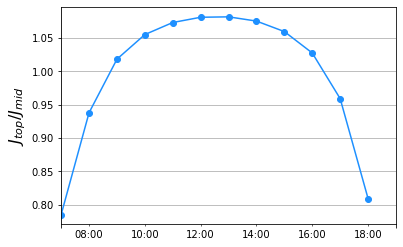

In [23]:
ratios.plot(color='dodgerblue', marker='o')
plt.ylabel('$J_{top} / J_{mid}$', fontsize=16)
plt.grid()